In [1]:
%tensorflow_version 2.x

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import gym

import tensorflow as tf

In [3]:
import urllib.request
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
!pip install unrar
!unrar x Roms.rar
!mkdir rars
!mv HC\ ROMS.zip   rars
!mv ROMS.zip  rars
!python -m atari_py.import_roms rars


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from Roms.rar

Extracting  HC ROMS.zip                                                   36%  OK 
Extracting  ROMS.zip                                                      74% 99%  OK 
All OK
copying adventure.bin from ROMS/Adventure (1980) (Atari, Warren Robinett) (CX2613, CX2613P) (PAL).bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/adventure.bin
copying air_raid.bin from ROMS/Air Raid (Men-A-Vision) (PAL) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/air_raid.bin
copying alien.bin from ROMS/Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/alien.bin
copying amidar.bin from ROMS/Amidar (1982) (Parker Brothers, Ed Temple) (PB5310) ~.bin to /usr/local/lib/python3.7/dist-packages/atari_py/atari_roms/amidar.bin
copying assault.bin from ROMS/Assau

In [4]:
env = gym.make('Pong-v0')

In [5]:
NUM_STATES = env.observation_space
NUM_ACTIONS = env.action_space.n

print('States: {}'.format(NUM_STATES))
print('Actions: {}'.format(NUM_ACTIONS))

States: Box(0, 255, (210, 160, 3), uint8)
Actions: 6


In [6]:
NUM_STATES.shape

(210, 160, 3)

In [7]:
lr = 0.1 # learning rate
gamma = 0.99 # параметр дисконтирования

NUM_EPISODES = 1000 # число эпизодов для обучения
MAX_STEPS = 100 # максимальное число шагов в эпизоде

REWARD_AVERAGE_WINDOW = 20 # окно для усреднения наград по эпизодам

In [8]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', 
                                 activation='relu', input_shape=NUM_STATES.shape)) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(NUM_ACTIONS, activation='relu'))

In [9]:
def evalQ(s):
    inp = np.array([s], dtype=np.int32)
    return model(inp).numpy()[0]

In [10]:
evalQ(env.reset())

array([  0.      ,   6.678376,  17.095833,  63.02433 , 105.55627 ,
         0.      ], dtype=float32)

In [11]:
evalQ(env.reset())[None, None, ...]

array([[[  0.      ,   6.678376,  17.095833,  63.02433 , 105.55627 ,
           0.      ]]], dtype=float32)

In [12]:
inp = np.array([env.reset()], dtype=np.int32)
inp.shape

(1, 210, 160, 3)

In [13]:
def loss(q1, q2):
    return tf.reduce_sum(tf.square(q1 - q2))

optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
model.compile(loss=loss, optimizer=optimizer)

In [14]:
model.train_on_batch(inp, evalQ(env.reset())[None, None, ...])

0.0

### Exploration + свёрточная нейросеть для аппроксимации Q-функции

In [15]:
pathLenList = [] # длины траекторий по эпизодам
totalRewardList = [] # суммарные награды по эпизодам
totalRewardAverageList = [] # суммарные награды по эпизодам (среднее по окну)

for i in range(NUM_EPISODES):
    #print(i)

    eps = 1.0 - i / NUM_EPISODES

    s = env.reset()

    totalReward = 0
    step = 0

    while step < MAX_STEPS:
        #print(step)
        step += 1

        Q_s = evalQ(s)
        
        # Exploration
        if np.random.rand() < eps:
            # Выбор случайного действия
            a = env.action_space.sample()
        else:
            # Выбор действия по текущей политике
            a = np.argmax(Q_s)
        
        # Сделать шаг
        s1, r, done, _ = env.step(a)

        Q_s1 = evalQ(s1)
        
        # Новое (целевое) значение Q-функции
        Q_target = Q_s
        if done:
            Q_target[a] = r
        else:
            Q_target[a] = r + gamma * np.max(Q_s1)
              
        # Обновление Q-функции
        inp = np.array([s], dtype=np.int32)
        model.train_on_batch(inp, Q_target[None, None, ...])
        
        totalReward += r
        s = s1
        
        # Если конец эпизода
        if done:
            break
            
    pathLenList.append(step)
    totalRewardList.append(totalReward)
    
    if i % REWARD_AVERAGE_WINDOW == 0 and i >= REWARD_AVERAGE_WINDOW:
        totalRewardAverage = np.mean(totalRewardList[-REWARD_AVERAGE_WINDOW:])
        totalRewardAverageList.append(totalRewardAverage)
        if i % 100 == 0:
            print('Episode {}: average total reward = {}'.format(i, totalRewardAverage))

Episode 100: average total reward = -0.85
Episode 200: average total reward = -0.95
Episode 300: average total reward = -0.85
Episode 400: average total reward = -1.0
Episode 500: average total reward = -0.85
Episode 600: average total reward = -0.9
Episode 700: average total reward = -0.85
Episode 800: average total reward = -0.75
Episode 900: average total reward = -0.75


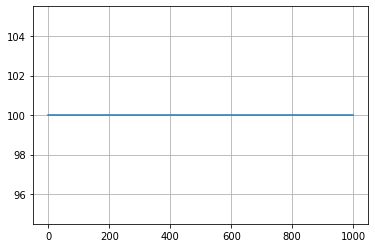

In [16]:
plt.plot(pathLenList)
plt.grid()

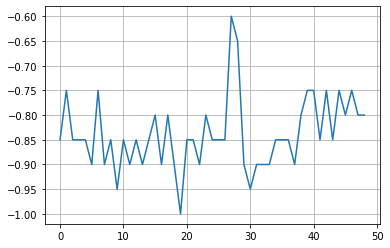

In [17]:
plt.plot(totalRewardAverageList)
plt.grid()

### Exploration + Experience Replay + свёрточная нейросеть для аппроксимации Q-функции

In [18]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', 
                                 activation='relu', input_shape=NUM_STATES.shape)) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(NUM_ACTIONS, activation='relu'))

In [19]:
model.compile(loss=loss, optimizer=optimizer)

In [ ]:
pathLenList = [] # длины траекторий по эпизодам
totalRewardList = [] # суммарные награды по эпизодам
totalRewardAverageList = [] # суммарные награды по эпизодам (среднее по окну)

BATCH_SIZE = 100
LEN_exp_rep = 200


for i in range(NUM_EPISODES):
    print(i)

    eps = 1.0 - i / NUM_EPISODES

    s = env.reset()

    totalReward = 0
    step = 0

    while step < MAX_STEPS:
        #print(step)
        step += 1

        Q_s = evalQ(s)

        # Exploration        
        if np.random.rand() < eps:
            # Выбор случайного действия
            a = env.action_space.sample()
        else:
            # Выбор действия по текущей политике
            a = np.argmax(Q_s)
        
        # Сделать шаг
        s1, r, done, _ = env.step(a)

        Q_s1 = evalQ(s1)
        
        # Новое (целевое) значение Q-функции
        Q_target = Q_s
        if done:
            Q_target[a] = r
        else:
            Q_target[a] = r + gamma * np.max(Q_s1)
              
        # Обновление Q-функции
        inp = np.array([s], dtype=np.int32)

        # Experience Replay
        if i == 0 and step == 1:
          inp_exp_rep = inp
          Q_target_exp_rep = Q_target[None, None, ...]
        else:
          inp_exp_rep = np.append(inp_exp_rep, inp, axis = 0)
          Q_target_exp_rep = np.append(Q_target_exp_rep, Q_target[None, None, ...], axis = 0)

        if inp_exp_rep.shape[0] > LEN_exp_rep:
          inp_exp_rep = inp_exp_rep[1:]
          Q_target_exp_rep = Q_target_exp_rep[1:]
        
        if inp_exp_rep.shape[0] < BATCH_SIZE:
          batch_size=inp_exp_rep.shape[0]
        else:
          batch_size=BATCH_SIZE
        #print(batch_size)
        model.fit(inp_exp_rep, Q_target_exp_rep, batch_size=batch_size, shuffle=True, verbose=0)
        
        totalReward += r
        s = s1
        
        # Если конец эпизода
        if done:
            break
            
    pathLenList.append(step)
    totalRewardList.append(totalReward)
    
    if i % REWARD_AVERAGE_WINDOW == 0 and i >= REWARD_AVERAGE_WINDOW:
        totalRewardAverage = np.mean(totalRewardList[-REWARD_AVERAGE_WINDOW:])
        totalRewardAverageList.append(totalRewardAverage)
        if i % 100 == 0:
            print('Episode {}: average total reward = {}'.format(i, totalRewardAverage))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
Episode 100: average total reward = -0.8
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
Episode 200: average total reward = -0.8
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241


In [ ]:
plt.plot(pathLenList)
plt.grid()

In [ ]:
plt.plot(totalRewardAverageList)
plt.grid()

In [ ]:
totalReward = 0
s = env.reset()

for _ in range(100):
    env.render()
    a = np.argmax(evalQ(s)) # выбираем оптимальное действие
    s, r, done, _ = env.step(a)
    totalReward += r
    if done:
        env.render()        
        break

env.close()
print('Total reward = {}'.format(totalReward))